In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import mplfinance as mpf
import os
import random

notebook_dir = Path().resolve()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root / 'src'))

import config

# Training datas

In [65]:
x_path = os.path.join('..', config.TRAIN_DATA_DIR, config.X_TRAIN_NAME)
l_path = os.path.join('..', config.TRAIN_DATA_DIR, config.L_TRAIN_NAME)
y_path = os.path.join('..', config.TRAIN_DATA_DIR, config.Y_TRAIN_NAME)

X_train = np.load(x_path)
L_train = np.load(l_path)
Y_train = np.load(y_path)

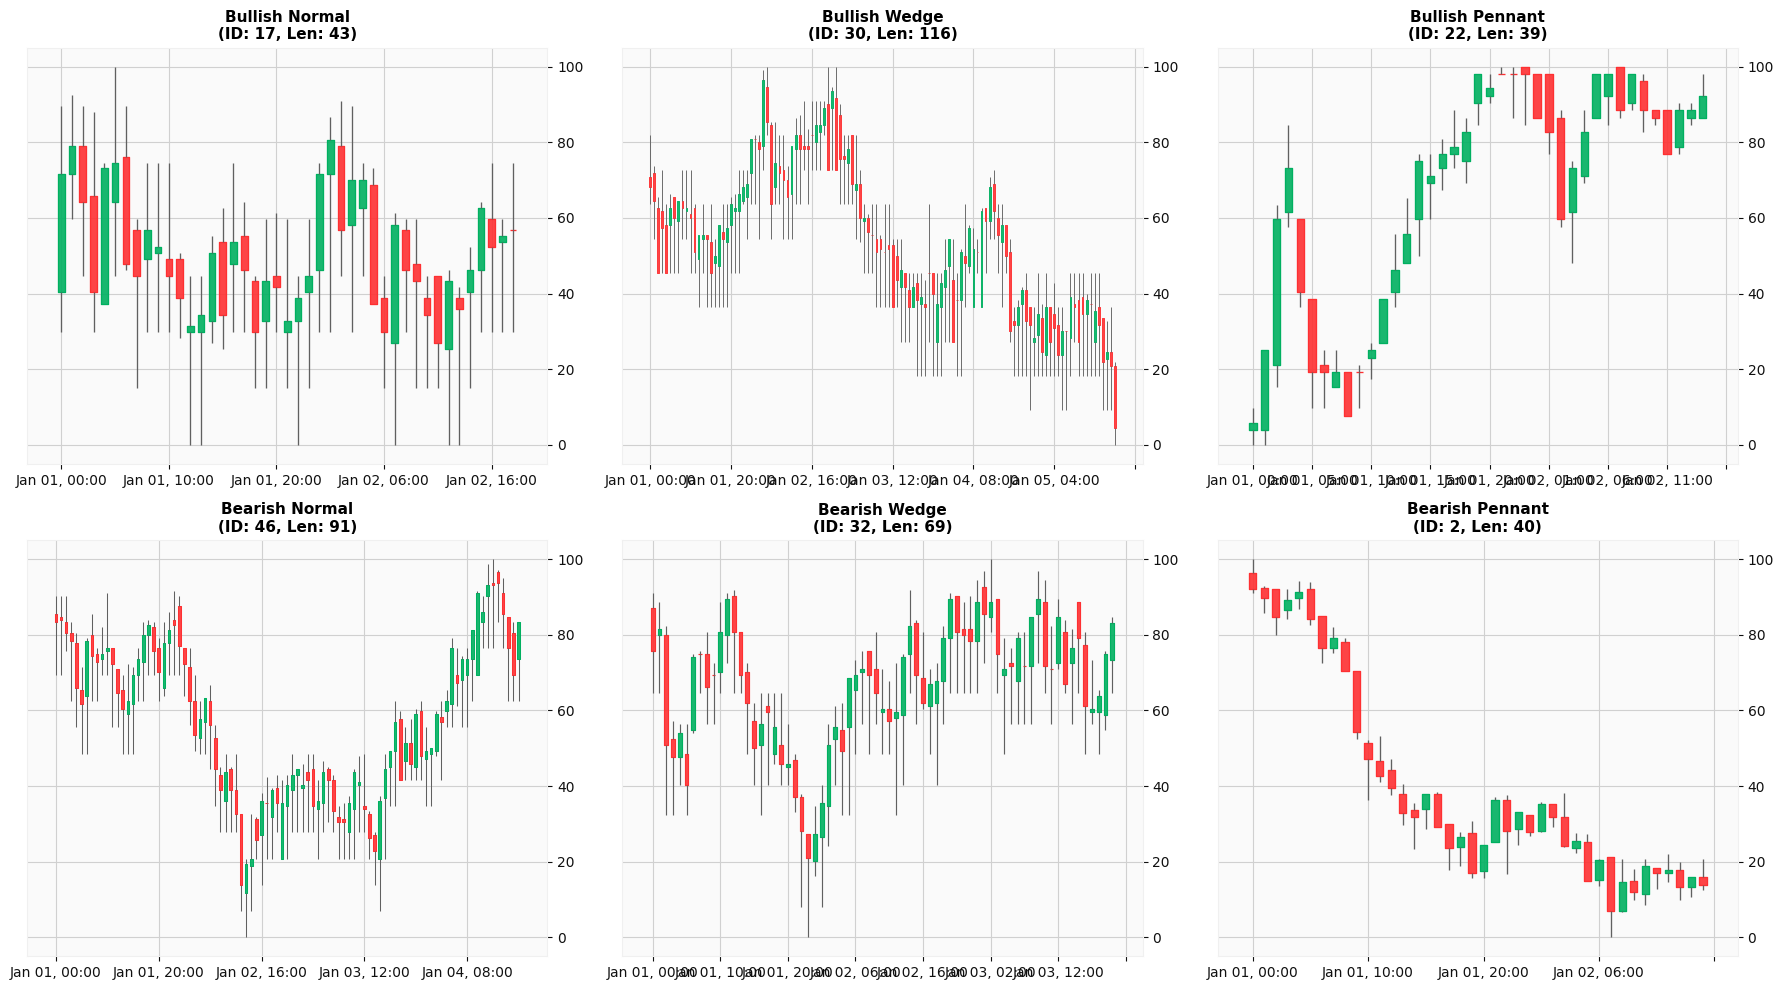

In [66]:
ID_TO_LABEL = {v: k for k, v in config.LABEL_MAP.items()}
unique_classes = np.sort(np.unique(Y_train))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, class_id in enumerate(unique_classes):
    indices = np.where(Y_train == class_id)[0]
    if len(indices) == 0: continue
    
    idx = random.choice(indices)
    
    sample = X_train[idx]
    real_len = L_train[idx]
    real_data = sample[:real_len].copy()
    
    scaled_data = real_data * 100
    
    df_candle = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close'])
    
    fake_start_date_for_index = '2024-01-01'
    df_candle.index = pd.date_range(start=fake_start_date_for_index, periods=len(df_candle), freq='h')
    
    class_name = ID_TO_LABEL.get(class_id, f"Class {class_id}")
    ax = axes[i]
    ax.set_title(f"{class_name}\n(ID: {idx}, Len: {real_len})", fontsize=11, fontweight='bold')
    
    mpf.plot(df_candle, 
            type='candle', 
            style='yahoo', 
            ax=ax, 
            ylabel='',
            xrotation=0)

plt.tight_layout()
plt.show()

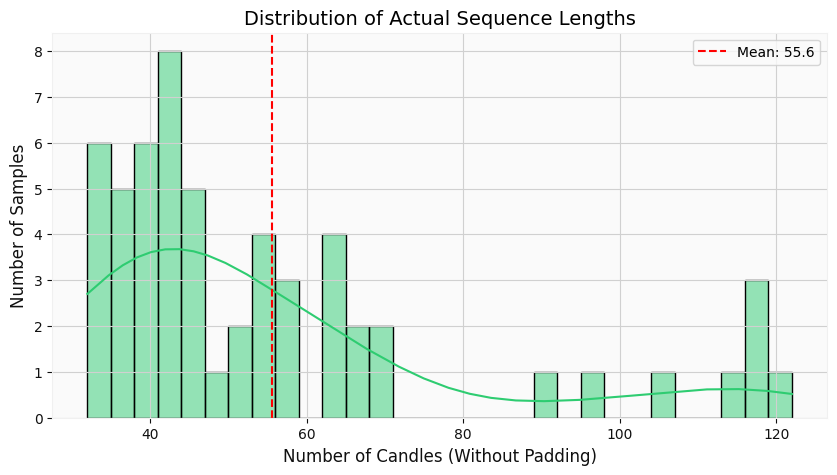

Total training samples: 56
Shortest sample: 32 candles
Longest sample: 122 candles
Model Input Size (Max Padding): 122
Average Fill Rate: 45.56%


In [67]:
plt.figure(figsize=(10, 5))
sns.histplot(L_train, bins=30, kde=True, color='#2ecc71')

plt.title('Distribution of Actual Sequence Lengths', fontsize=14)
plt.xlabel('Number of Candles (Without Padding)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

mean_len = np.mean(L_train)
max_len_in_data = np.max(L_train)
model_input_len = X_train.shape[1]

plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f}')
plt.legend()
plt.show()

print(f"Total training samples: {len(L_train)}")
print(f"Shortest sample: {np.min(L_train)} candles")
print(f"Longest sample: {max_len_in_data} candles")
print(f"Model Input Size (Max Padding): {model_input_len}")
print(f"Average Fill Rate: {(mean_len / model_input_len) * 100:.2f}%")

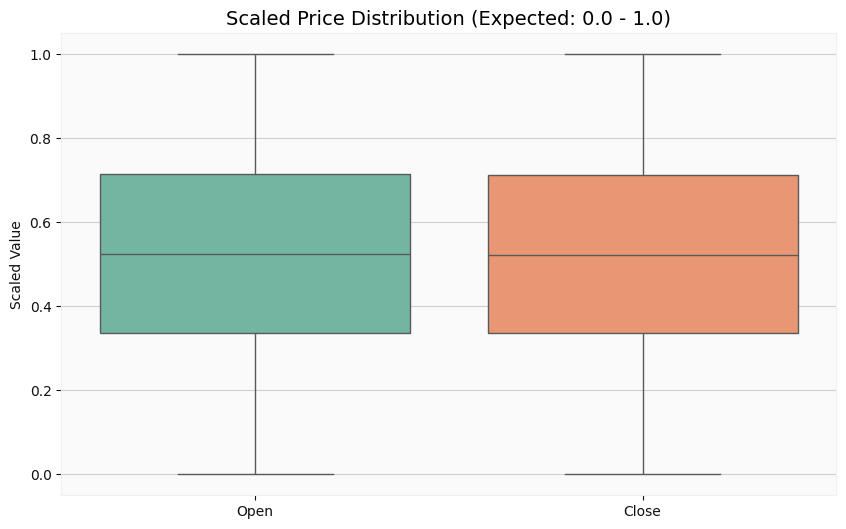

Statistics (Close Price):
	Min: 0.0000
	Max: 1.0000
	Mean: 0.5245


In [68]:
flat_open = []
flat_close = []

for i in range(len(X_train)):
    real_len = L_train[i]
    flat_open.extend(X_train[i, :real_len, 0])
    flat_close.extend(X_train[i, :real_len, 3])

df_stats = pd.DataFrame({'Open': flat_open, 'Close': flat_close})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_stats, palette="Set2")
plt.title('Scaled Price Distribution (Expected: 0.0 - 1.0)', fontsize=14)
plt.ylabel('Scaled Value')
plt.grid(True, axis='y')
plt.show()

print("Statistics (Close Price):")
print(f"\tMin: {np.min(flat_close):.4f}")
print(f"\tMax: {np.max(flat_close):.4f}")
print(f"\tMean: {np.mean(flat_close):.4f}")


SAMPLE #43 | LENGTH: 116 candles


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


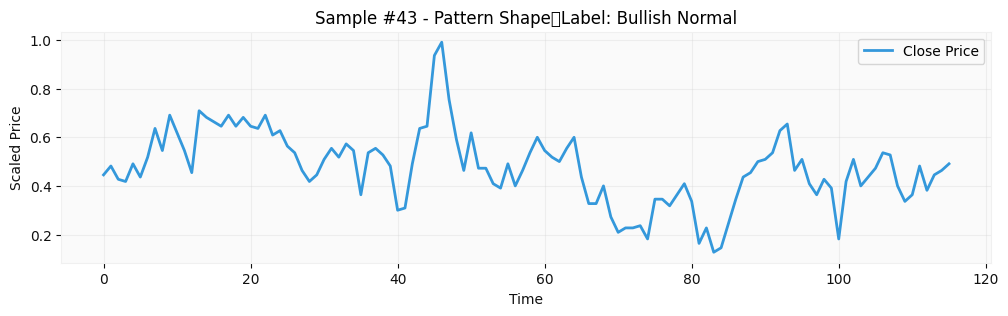

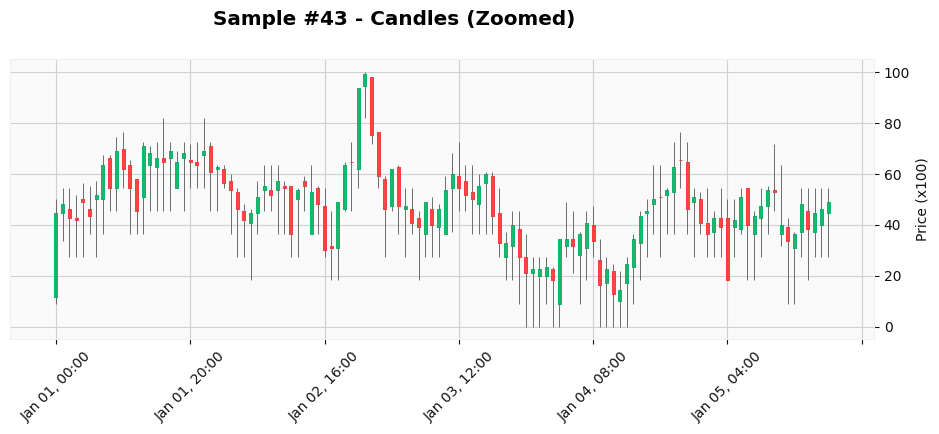


SAMPLE #19 | LENGTH: 66 candles


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


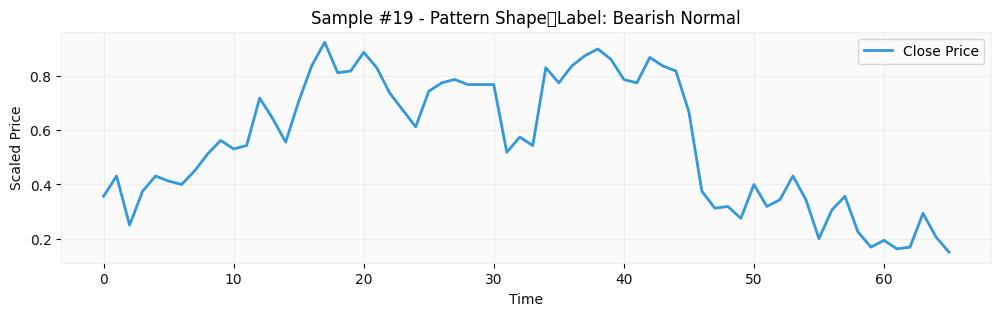

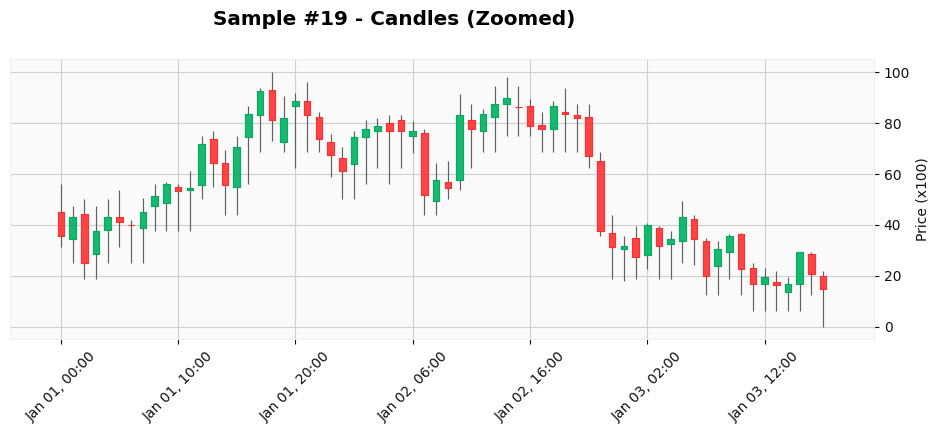


SAMPLE #41 | LENGTH: 54 candles


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


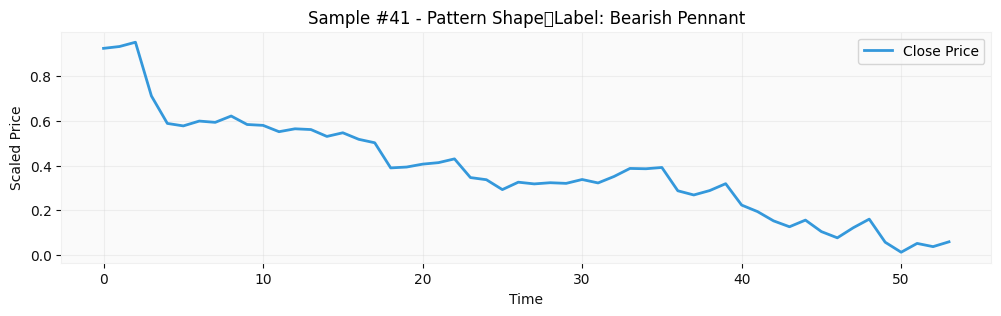

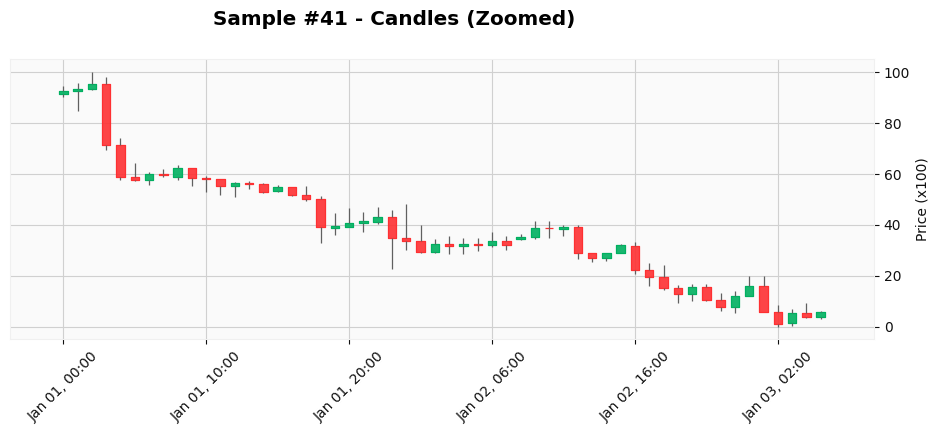

In [69]:
indices = random.sample(range(len(X_train)), 3)

for idx in indices:
    sample = X_train[idx]
    real_len = L_train[idx]
    label = Y_train[idx]

    real_data = sample[:real_len].copy()

    print(f"\n{'='*60}")
    print(f"SAMPLE #{idx} | LENGTH: {real_len} candles")
    print(f"{'='*60}")

    class_name = ID_TO_LABEL.get(label, f"Class {label}")

    plt.figure(figsize=(12, 3))
    plt.plot(real_data[:, 3], label='Close Price', color='#3498db', linewidth=2)
    plt.title(f'Sample #{idx} - Pattern Shape\tLabel: {class_name}', fontsize=12)
    plt.xlabel('Time')
    plt.ylabel('Scaled Price')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    scaled_up_data = real_data * 100

    df_candle = pd.DataFrame(scaled_up_data, columns=['Open', 'High', 'Low', 'Close'])
    df_candle.index = pd.date_range(start='2024-01-01', periods=len(df_candle), freq='h')

    try:
        mpf.plot(df_candle, type='candle', style='yahoo',
                 title=f'Sample #{idx} - Candles (Zoomed)',
                 ylabel='Price (x100)',
                 figsize=(12, 4))
    except Exception as e:
        print(f"Failed to plot candles: {e}")

# Test datas

In [70]:
x_test_path = os.path.join('..', config.TEST_DATA_DIR, config.X_TEST_NAME)
l_test_path = os.path.join('..', config.TEST_DATA_DIR, config.L_TEST_NAME)
y_test_path = os.path.join('..', config.TEST_DATA_DIR, config.Y_TEST_NAME)

X_test = np.load(x_test_path)
L_test = np.load(l_test_path)
Y_test = np.load(y_test_path)

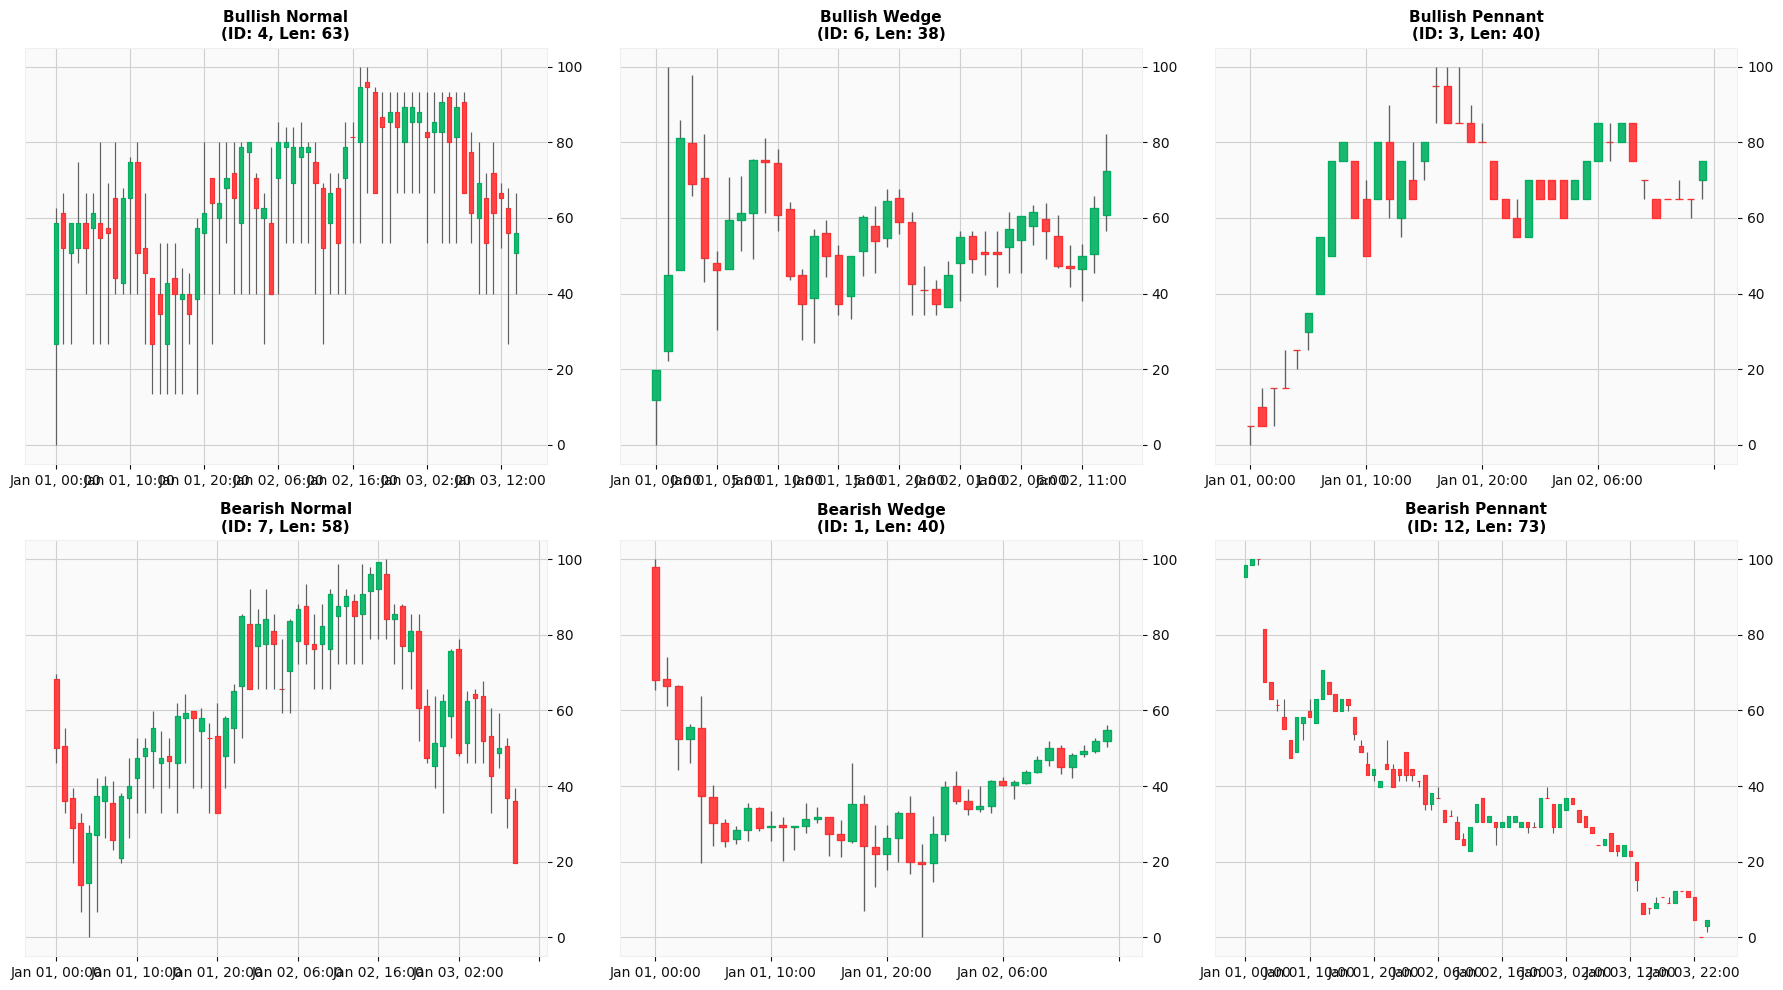

In [71]:
ID_TO_LABEL = {v: k for k, v in config.LABEL_MAP.items()}
unique_classes = np.sort(np.unique(Y_test))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, class_id in enumerate(unique_classes):
    indices = np.where(Y_test == class_id)[0]
    if len(indices) == 0: continue
    
    idx = random.choice(indices)
    
    sample = X_test[idx]
    real_len = L_test[idx]
    real_data = sample[:real_len].copy()
    
    scaled_data = real_data * 100
    
    df_candle = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close'])
    
    fake_start_date_for_index = '2024-01-01'
    df_candle.index = pd.date_range(start=fake_start_date_for_index, periods=len(df_candle), freq='h')
    
    class_name = ID_TO_LABEL.get(class_id, f"Class {class_id}")
    ax = axes[i]
    ax.set_title(f"{class_name}\n(ID: {idx}, Len: {real_len})", fontsize=11, fontweight='bold')
    
    mpf.plot(df_candle, 
            type='candle', 
            style='yahoo', 
            ax=ax, 
            ylabel='',
            xrotation=0)

plt.tight_layout()
plt.show()

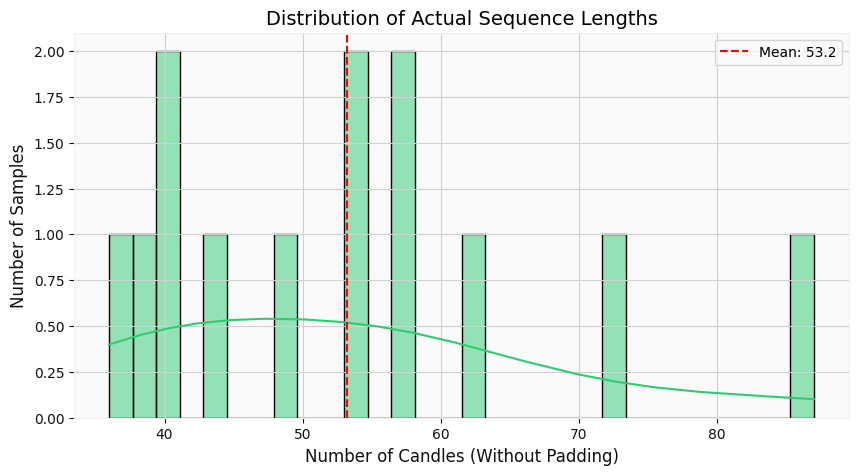

Total testing samples: 13
Shortest sample: 36 candles
Longest sample: 87 candles
Model Input Size (Max Padding): 122
Average Fill Rate: 43.63%


In [72]:
plt.figure(figsize=(10, 5))
sns.histplot(L_test, bins=30, kde=True, color='#2ecc71')

plt.title('Distribution of Actual Sequence Lengths', fontsize=14)
plt.xlabel('Number of Candles (Without Padding)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

mean_len = np.mean(L_test)
max_len_in_data = np.max(L_test)
model_input_len = X_test.shape[1]

plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f}')
plt.legend()
plt.show()

print(f"Total testing samples: {len(L_test)}")
print(f"Shortest sample: {np.min(L_test)} candles")
print(f"Longest sample: {max_len_in_data} candles")
print(f"Model Input Size (Max Padding): {model_input_len}")
print(f"Average Fill Rate: {(mean_len / model_input_len) * 100:.2f}%")

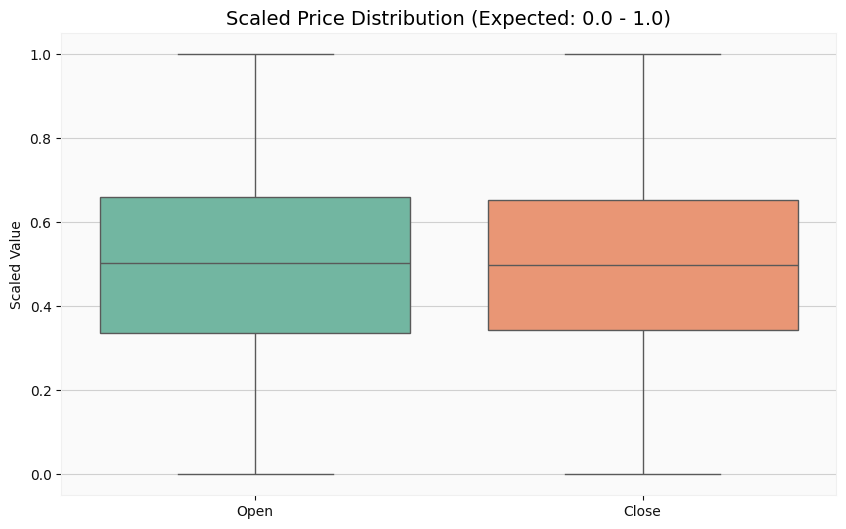

Statistics (Close Price):
	Min: 0.0000
	Max: 1.0000
	Mean: 0.5027


In [73]:
flat_open = []
flat_close = []

for i in range(len(X_test)):
    real_len = L_test[i]
    flat_open.extend(X_test[i, :real_len, 0])
    flat_close.extend(X_test[i, :real_len, 3])

df_stats = pd.DataFrame({'Open': flat_open, 'Close': flat_close})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_stats, palette="Set2")
plt.title('Scaled Price Distribution (Expected: 0.0 - 1.0)', fontsize=14)
plt.ylabel('Scaled Value')
plt.grid(True, axis='y')
plt.show()

print("Statistics (Close Price):")
print(f"\tMin: {np.min(flat_close):.4f}")
print(f"\tMax: {np.max(flat_close):.4f}")
print(f"\tMean: {np.mean(flat_close):.4f}")


SAMPLE #12 | LENGTH: 73 candles


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


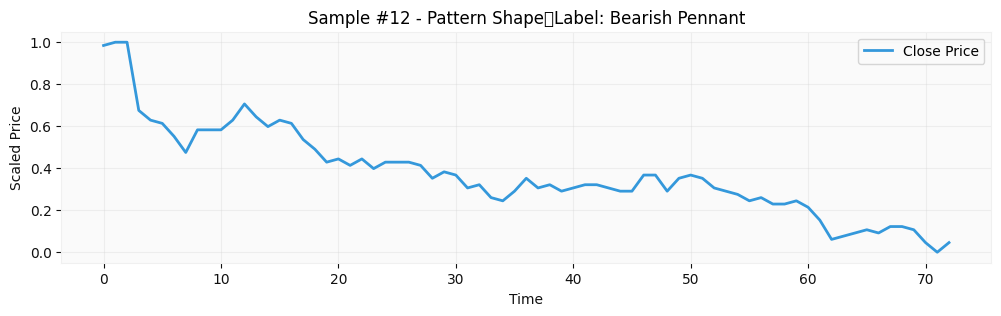

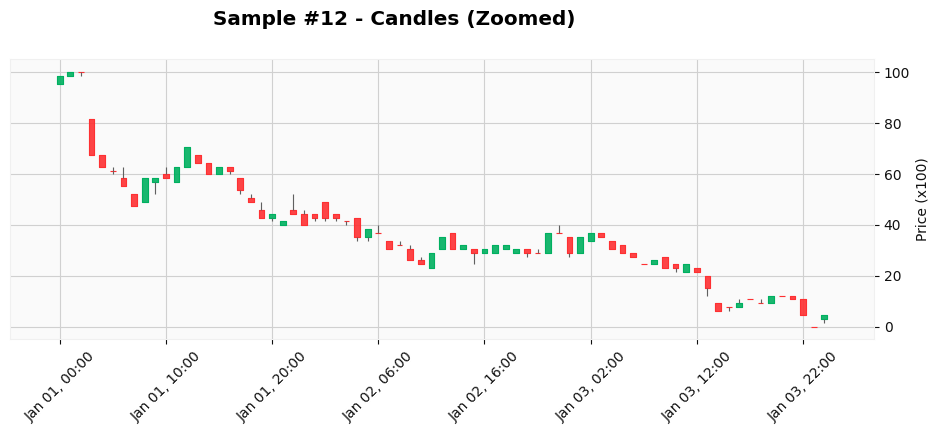


SAMPLE #2 | LENGTH: 87 candles


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


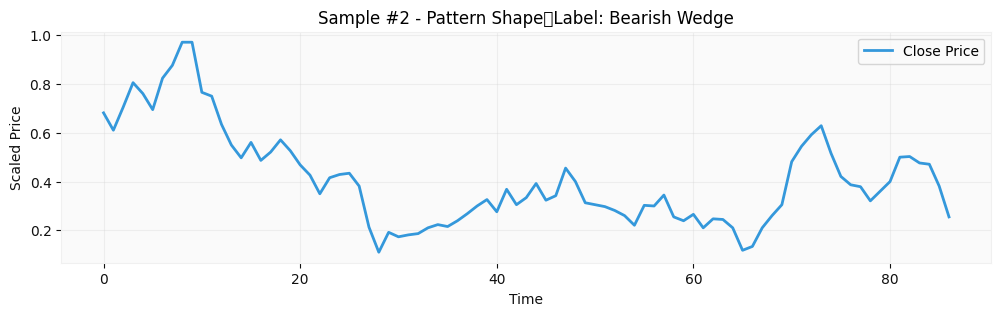

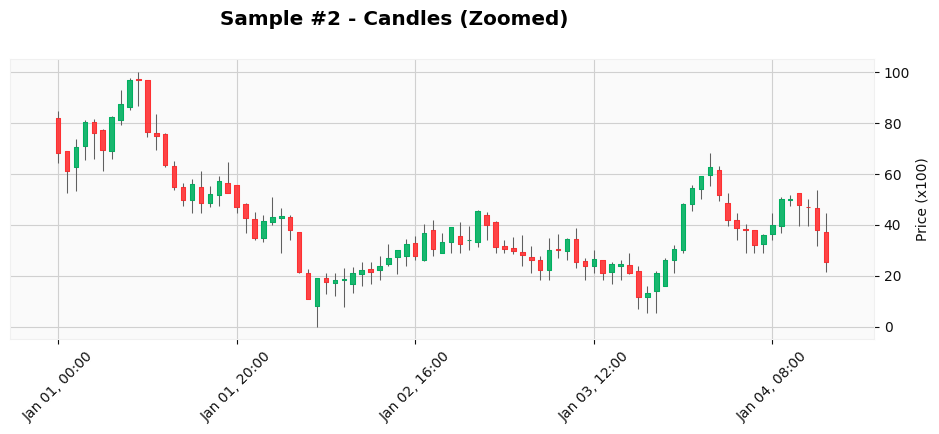


SAMPLE #1 | LENGTH: 40 candles


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


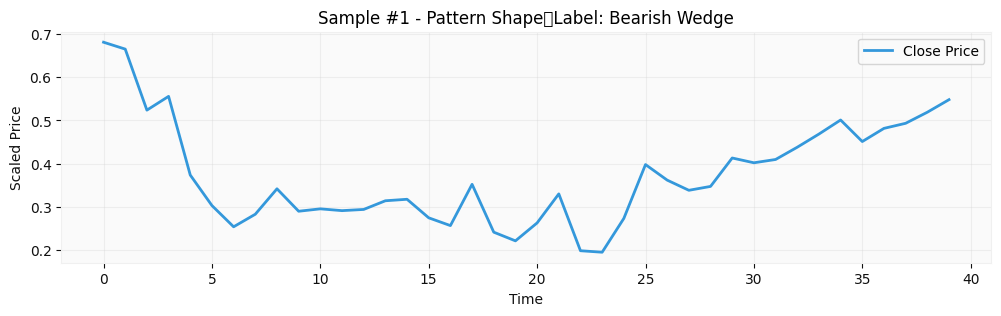

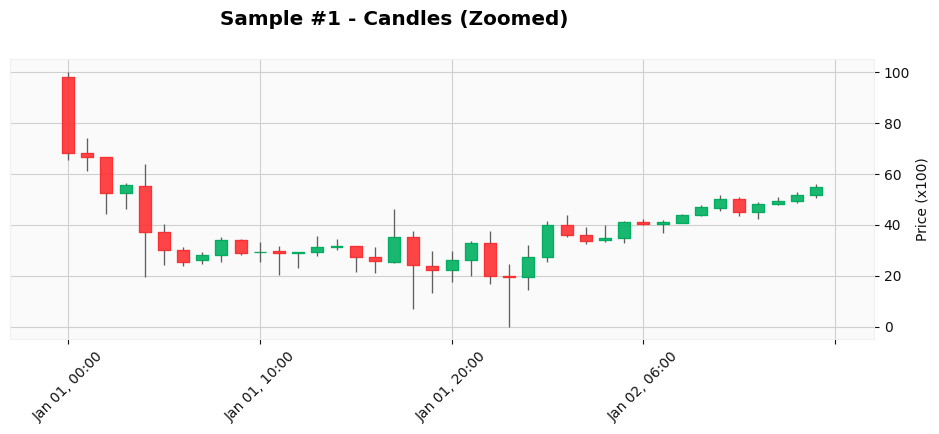

In [74]:
indices = random.sample(range(len(X_test)), 3)

for idx in indices:
    sample = X_test[idx]
    real_len = L_test[idx]
    label = Y_test[idx]

    real_data = sample[:real_len].copy()

    print(f"\n{'='*60}")
    print(f"SAMPLE #{idx} | LENGTH: {real_len} candles")
    print(f"{'='*60}")

    class_name = ID_TO_LABEL.get(label, f"Class {label}")

    plt.figure(figsize=(12, 3))
    plt.plot(real_data[:, 3], label='Close Price', color='#3498db', linewidth=2)
    plt.title(f'Sample #{idx} - Pattern Shape\tLabel: {class_name}', fontsize=12)
    plt.xlabel('Time')
    plt.ylabel('Scaled Price')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    scaled_up_data = real_data * 100

    df_candle = pd.DataFrame(scaled_up_data, columns=['Open', 'High', 'Low', 'Close'])
    df_candle.index = pd.date_range(start='2024-01-01', periods=len(df_candle), freq='h')

    try:
        mpf.plot(df_candle, type='candle', style='yahoo',
                 title=f'Sample #{idx} - Candles (Zoomed)',
                 ylabel='Price (x100)',
                 figsize=(12, 4))
    except Exception as e:
        print(f"Failed to plot candles: {e}")

# Conclusion

As can be seen from the data, the sequences vary significantly in length and exhibit highly diverse patterns compared to the "textbook-perfect" examples. This variability makes flag pattern recognition more challenging for the neural network. The average fill rate is adequate, with the remaining portion padded with zeros.